Importujemy potrzebne biblioteki oraz ustawiamy ilość testów

In [27]:
#Zastosowane w piewszym i drugim modelu
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

num_of_experiments = 5

Wczytujemy dane z plików "horseColicTraining" oraz "horseColicTest" i zapisujemy je w zmiennych trainingSet, trainingLabels oraz testSet, testLabels. Tworzymy listy do przechowywania dokładności modeli.

In [28]:
# Funkcja wczytująca dane z pliku "file_name", zapisuje dane w zmiennych "data_set" (cechy) i "data_labels" (etykiety)
def load_data(file_name):
    data_set = []
    data_labels = []
    with open(file_name) as fr:
        for line in fr.readlines():
            curr_line = line.strip().split('\t') # Rozdzielamy dane na kolumny (dane oddzielone tabulatorem)
            line_arr = [float(curr_line[i]) for i in range(21)]  # Pierwsze 21 kolumn to cechy
            data_set.append(line_arr) # Dodajemy cechy do data_set
            data_labels.append(float(curr_line[21]))  # 22 kolumna to etykiety. Dodajemy etykiety do data_labels
    return np.array(data_set), np.array(data_labels)

# Wczytujemy zestawy danych treningowych i testowych
trainingSet, trainingLabels = load_data('horseColicTraining.txt')
testSet, testLabels = load_data('horseColicTest.txt')

accuracy_logreg = []
accuracy_log = []
accuracy_tree = []

Tworzymy funkcje do generowania także dane, aby przeprowadzić na nich testy. Tworzymy listy do przechowywania dokładności modeli.

In [29]:
def generate_data(n_samples=500, n_features=5):
    # X: macierz o rozmiarze (n_samples, n_features) z losowymi wartościami z zakresu [0, 1]
    # y: wektor etykiet (0 lub 1) o długości n_samples
    X = np.random.rand(n_samples, n_features)  
    y = np.random.randint(0, 2, size=n_samples)  
    return X, y

Zaimplementowanie modelu regresji logistycznej na przykładzie podanym na https://github.com/pbharrin/machinelearninginaction

In [30]:
# Funkcja sigmoid — oblicza prawdopodobieństwo na podstawie funkcji logistycznej
def sigmoid(inX):
    return 1.0 / (1 + np.exp(-inX)) # Funkcja logistyczna, która zwraca wartości w przedziale (0, 1)

# Funkcja klasyfikująca wektor cech na podstawie wagi modelu
def classifyVector(inX, weights):
    prob = sigmoid(sum(inX * weights)) # Obliczamy prawdopodobieństwo
    return 1.0 if prob > 0.5 else 0.0 # Zwracamy 1.0 jeśli prawdopodobieństwo > 0.5, w przeciwnym razie 0.0

def LogRegress(dataMatrix, classLabels, numIter=150, learning_rate=0.001):  # Dodajemy learning_rate aby usprawnić model
    m, n = np.shape(dataMatrix) # m — liczba próbek, n — liczba cech
    weights = np.ones(n)   #  Inicjalizujemy wagi na wartość 1
    for j in range(numIter):
        dataIndex = list(range(m))
        for i in range(m): # Dla każdej próbki
            alpha = learning_rate / (1.0 + j + i) + 0.0001
            randIndex = int(np.random.uniform(0, len(dataIndex)))  
            h = sigmoid(sum(dataMatrix[randIndex] * weights)) # Obliczamy prawdopodobieństwo przy użyciu funkcji sigmoid
            error = classLabels[randIndex] - h
            weights = weights + alpha * error * dataMatrix[randIndex]
            del(dataIndex[randIndex])  # Usuwamy użyty indeks, by nie powtarzać tej samej próbki
    return weights

Uczenie modeli LogRegress, LogisticRegression (Scikit-learn) i DecisionTreeClassifier (Scikit-learn) na "przetasowanych" danych HorseColic oraz wyświetlanie wykresu Ground Truth po przeprowadzeniu podanej ilości testów.

In [31]:
# Funkcja do przeprowadzania wielu eksperymentów i zbierania predykcji
def MultiTestHorse(num_experiments):
    # Listy do przechowywania dokładności modeli
    accuracy_logreg = []
    accuracy_log = []
    accuracy_tree = []

    # Listy do zbierania wszystkich predykcji z każdego eksperymentu
    all_predictions_logreg = []
    all_predictions_log = []
    all_predictions_tree = []

    for i in range(num_experiments):
        # Tasowanie i dzielenie zbioru treningowego losowo w każdym eksperymencie
        indices = np.random.permutation(len(trainingSet))  # Losowe permutowanie indeksów zbioru treningowego
        shuffled_trainingSet = trainingSet[indices] 
        shuffled_trainingLabels = trainingLabels[indices]

        # Trenowanie przykładowego modelu regresji logistycznej
        trainWeights = LogRegress(shuffled_trainingSet, shuffled_trainingLabels, 1000, 0.01) 
        predictions_logreg = [classifyVector(sample, trainWeights) for sample in testSet]  # Obliczanie prawdopodobieństw dla zbioru testowego (Predykcja)
        all_predictions_logreg.extend(predictions_logreg)  
        acc_logreg = accuracy_score(testLabels, predictions_logreg)  # Obliczanie dokładności
        accuracy_logreg.append(acc_logreg)  


        # Trenowanie modelu regresji logistycznej z scikit-learn
        log_model = LogisticRegression(max_iter=2000) 
        log_model.fit(shuffled_trainingSet, shuffled_trainingLabels) 
        predictions_log = log_model.predict(testSet)  # Obliczanie prawdopodobieństw dla zbioru testowego (Predykcja)
        all_predictions_log.extend(predictions_log)  
        acc_log = accuracy_score(testLabels, predictions_log)  # Obliczanie dokładności
        accuracy_log.append(acc_log) 

        # Trenowanie modelu drzewa decyzyjnego z scikit-learn
        tree_model = DecisionTreeClassifier()  
        tree_model.fit(shuffled_trainingSet, shuffled_trainingLabels)  
        predictions_tree = tree_model.predict(testSet)  # Obliczanie prawdopodobieństw dla zbioru testowego (Predykcja)
        all_predictions_tree.extend(predictions_tree) 
        acc_tree = accuracy_score(testLabels, predictions_tree)  # Obliczanie dokładności
        accuracy_tree.append(acc_tree) 

    return all_predictions_logreg, all_predictions_log, all_predictions_tree, accuracy_tree, accuracy_log, accuracy_logreg


Uczenie modeli LogRegress, LogisticRegression (Scikit-learn) i DecisionTreeClassifier (Scikit-learn) na wygenerowanych danych oraz wyświetlanie wykresu Ground Truth po przeprowadzeniu podanej ilości testów.

In [32]:
# Funkcja do przeprowadzania wielu eksperymentów na syntetycznych danych
def MultiTestSynth(num_experiments):
    # Listy do przechowywania dokładności modeli
    accuracy_logreg_generated = []
    accuracy_log_generated = []
    accuracy_tree_generated = []

    # Listy do zbierania wszystkich predykcji z każdego eksperymentu
    all_predictions_logreg_generated = []
    all_predictions_log_generated = []
    all_predictions_tree_generated = []

    for i in range(num_experiments):
        # Generowanie syntetycznego zbioru danych
        generated_X, generated_y = generate_data()
        
        # Podział danych syntetycznych na zbiór treningowy i testowy (80/20)
        split_index = int(0.8 * len(generated_X))
        X_train, X_test = generated_X[:split_index], generated_X[split_index:]
        y_train, y_test = generated_y[:split_index], generated_y[split_index:]

        # Trenowanie niestandardowego modelu regresji logistycznej
        trainWeights = LogRegress(X_train, y_train, 1000, 0.01) 
        predictions_logreg = [classifyVector(sample, trainWeights) for sample in X_test]  # Obliczanie prawdopodobieństw dla zbioru testowego (Predykcja)
        all_predictions_logreg_generated.extend(predictions_logreg) 
        acc_logreg = accuracy_score(y_test, predictions_logreg)  # Obliczanie dokładności
        accuracy_logreg_generated.append(acc_logreg) 

        # Trenowanie modelu regresji logistycznej z scikit-learn
        log_model = LogisticRegression(max_iter=2000)
        log_model.fit(X_train, y_train)  
        predictions_log = log_model.predict(X_test)  # Obliczanie prawdopodobieństw dla zbioru testowego (Predykcja)
        all_predictions_log_generated.extend(predictions_log) 
        acc_log = accuracy_score(y_test, predictions_log)  # Obliczanie dokładności
        accuracy_log_generated.append(acc_log) 

        # Trenowanie modelu drzewa decyzyjnego
        tree_model = DecisionTreeClassifier()
        tree_model.fit(X_train, y_train)
        predictions_tree = tree_model.predict(X_test)  # Obliczanie prawdopodobieństw dla zbioru testowego (Predykcja)
        all_predictions_tree_generated.extend(predictions_tree)
        acc_tree = accuracy_score(y_test, predictions_tree)  # Obliczanie dokładności
        accuracy_tree_generated.append(acc_tree)

    return y_test, all_predictions_logreg_generated, all_predictions_log_generated, all_predictions_tree_generated, accuracy_logreg_generated, accuracy_log_generated, accuracy_tree_generated


Wyświetlanie wykresów Dokładności i Ground Truth dla danych HorseColic

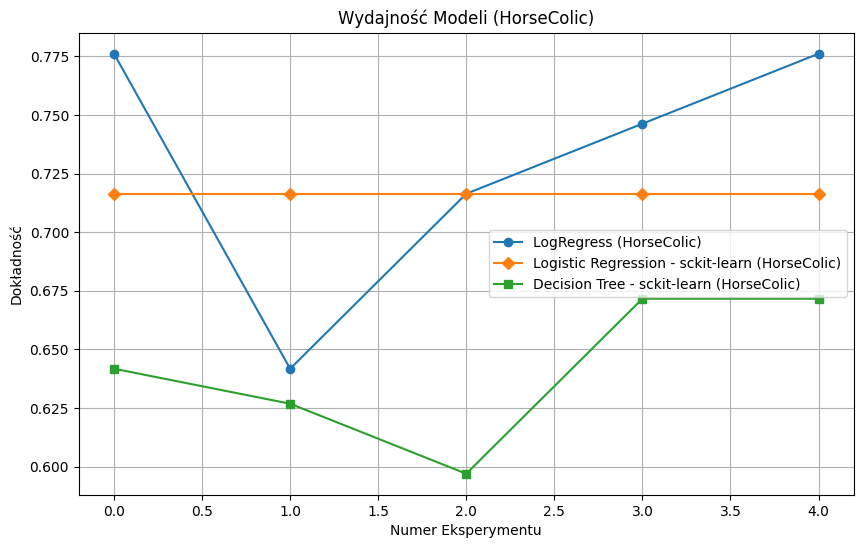


Średnia dokładność przykładowej regresji logistycznej: 73.13%
Średnia dokładność regresji logistycznej (scikit-Learn): 71.64%
Średnia dokładność klasyfikatora drzewa decyzyjnego (scikit-Learn): 64.18% 



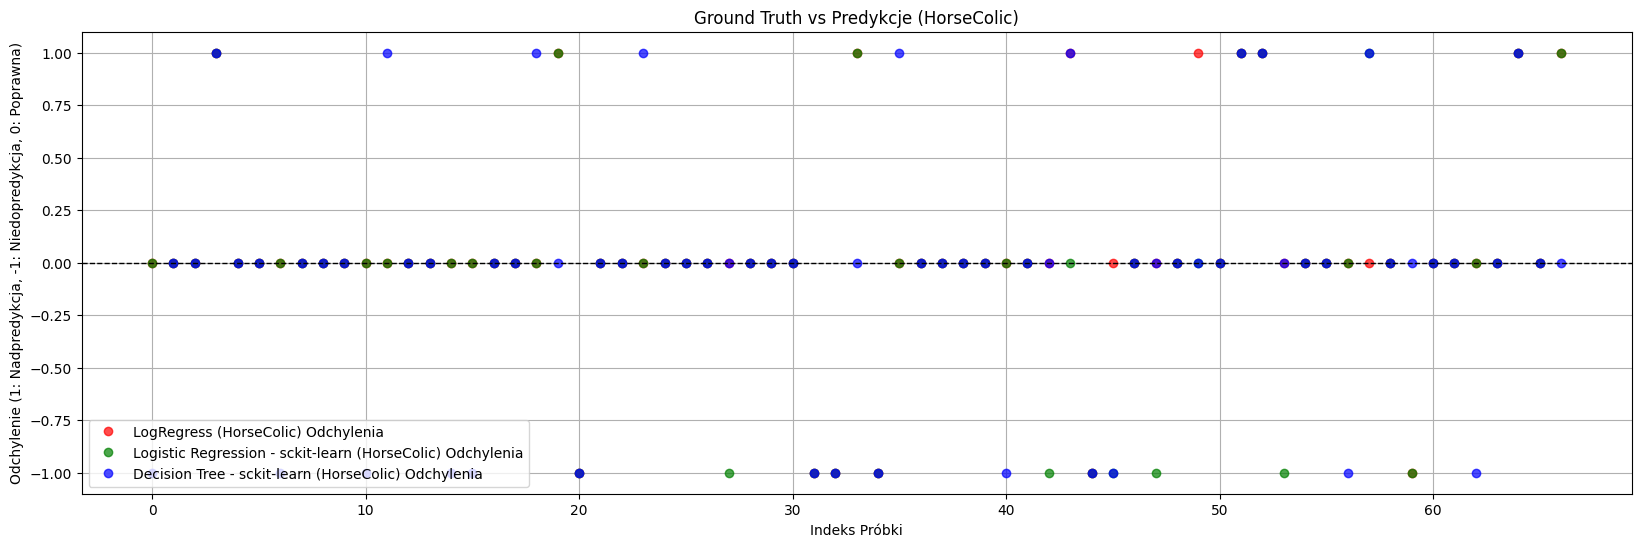

In [33]:
all_predictions_logreg, all_predictions_log, all_predictions_tree, accuracy_tree, accuracy_log, accuracy_logreg = MultiTestHorse(num_of_experiments)

# Tworzenie wykresu dla dokładności modeli w kolejnych eksperymentach na danych HorseColic
plt.figure(figsize=(10, 6))
plt.plot(range(num_of_experiments), accuracy_logreg, marker='o', label="LogRegress (HorseColic)") 
plt.plot(range(num_of_experiments), accuracy_log, marker='D', label="Logistic Regression - sckit-learn (HorseColic)")
plt.plot(range(num_of_experiments), accuracy_tree, marker='s', label="Decision Tree - sckit-learn (HorseColic)")
plt.xlabel("Numer Eksperymentu")
plt.ylabel("Dokładność")
plt.title("Wydajność Modeli (HorseColic)")
plt.legend()
plt.grid(True)
plt.show()

# Wypisywanie średnich dokładności dla każdego modelu
print("\nŚrednia dokładność przykładowej regresji logistycznej: {:.2f}%".format(np.mean(accuracy_logreg) * 100))
print("Średnia dokładność regresji logistycznej (scikit-Learn): {:.2f}%".format(np.mean(accuracy_log) * 100))
print("Średnia dokładność klasyfikatora drzewa decyzyjnego (scikit-Learn): {:.2f}% \n".format(np.mean(accuracy_tree) * 100))

# Definicja funkcji obliczającej i wykresującej odchylenia na danych HorseColic
true_labels = testLabels
all_predictions = [all_predictions_logreg, all_predictions_log, all_predictions_tree] 
labels = ["LogRegress (HorseColic)", "Logistic Regression - sckit-learn (HorseColic)", "Decision Tree - sckit-learn (HorseColic)"]
title = "Ground Truth vs Predykcje"
plt.figure(figsize=(20, 6)) # Tworzenie wykresu odchyleń dla wszystkich modeli na danych HorseColic
colors = ['red', 'green', 'blue'] 

for predictions, label, color in zip(all_predictions, labels, colors):
    # Obliczanie odchyleń: 1 dla nadpredyckji, -1 dla niedopredykcji, 0 dla poprawnych
    deviations = [1 if pred > true else -1 if pred < true else 0 for true, pred in zip(true_labels, predictions)]
    plt.plot(deviations, marker='o', linestyle='', label=f'{label} Odchylenia', alpha=0.7, color=color)

plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Linia bazowa dla braku odchylenia
plt.title("Ground Truth vs Predykcje (HorseColic)")
plt.xlabel('Indeks Próbki') 
plt.ylabel('Odchylenie (1: Nadpredykcja, -1: Niedopredykcja, 0: Poprawna)')
plt.legend() 
plt.grid(True)
plt.show()


Uczenie modeli LogRegress, LogisticRegression (Scikit-learn) i DecisionTreeClassifier (Scikit-learn) na wygenerowanych danych oraz wyświetlanie wykresu Ground Truth po przeprowadzeniu podanej ilości testów.

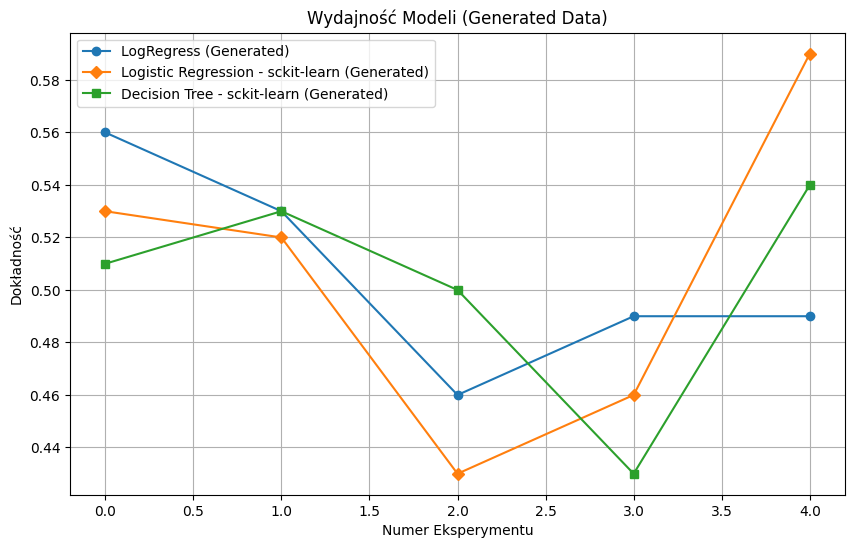


Średnia dokładność na danych syntetycznych - Niestandardowa Regresja Logistyczna: 50.60%
Średnia dokładność na danych syntetycznych - Regresja Logistyczna (Scikit-Learn): 50.60%
Średnia dokładność na danych syntetycznych - Drzewo Decyzyjne (Scikit-Learn): 50.20% 



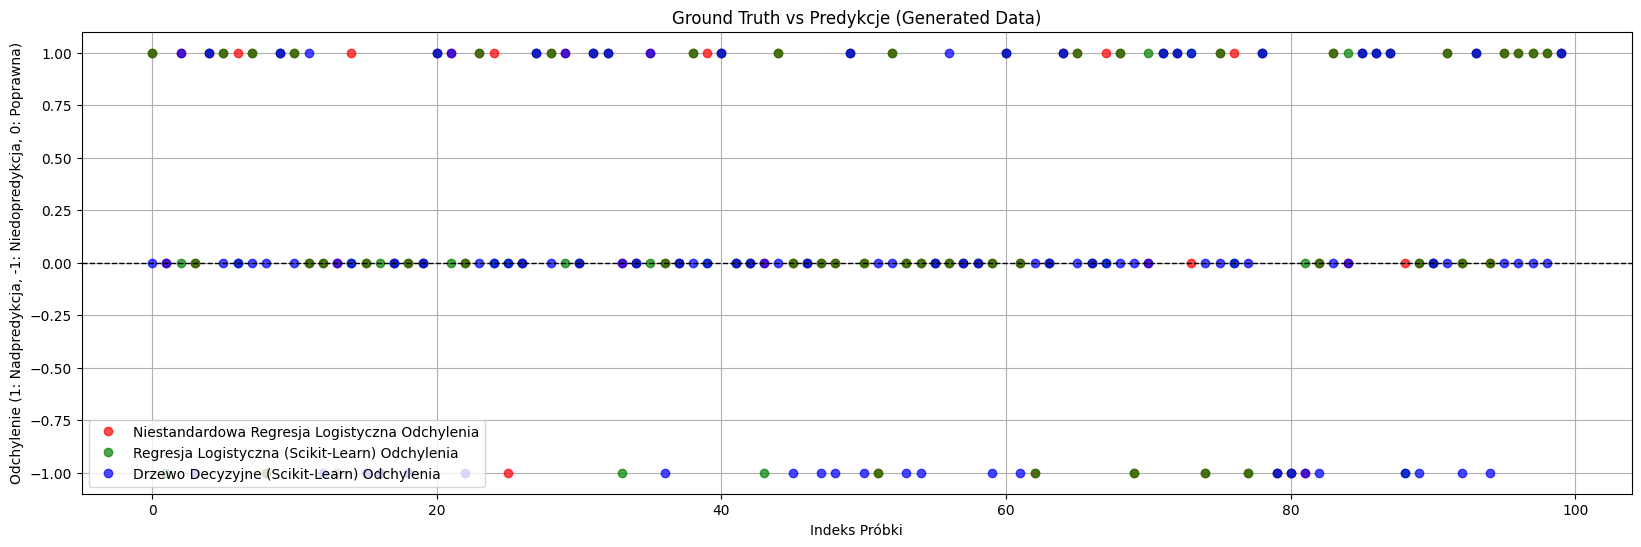

In [34]:
y_test, all_predictions_logreg_generated, all_predictions_log_generated, all_predictions_tree_generated, accuracy_logreg_generated, accuracy_log_generated, accuracy_tree_generated = MultiTestSynth(num_of_experiments)

# Tworzenie wykresu dla dokładności modeli w kolejnych eksperymentach na wygenerowanych danych
plt.figure(figsize=(10, 6))
plt.plot(range(num_of_experiments), accuracy_logreg_generated, marker='o', label="LogRegress (Generated)") 
plt.plot(range(num_of_experiments), accuracy_log_generated, marker='D', label="Logistic Regression - sckit-learn (Generated)")
plt.plot(range(num_of_experiments), accuracy_tree_generated, marker='s', label="Decision Tree - sckit-learn (Generated)")
plt.xlabel("Numer Eksperymentu") 
plt.ylabel("Dokładność")
plt.title("Wydajność Modeli (Generated Data)")
plt.legend()
plt.grid(True)
plt.show()

# Wyświetlenie średnich dokładności na wygenerowanych danych
print("\nŚrednia dokładność na danych syntetycznych - Niestandardowa Regresja Logistyczna: {:.2f}%".format(np.mean(accuracy_logreg_generated) * 100))
print("Średnia dokładność na danych syntetycznych - Regresja Logistyczna (Scikit-Learn): {:.2f}%".format(np.mean(accuracy_log_generated) * 100))
print("Średnia dokładność na danych syntetycznych - Drzewo Decyzyjne (Scikit-Learn): {:.2f}% \n".format(np.mean(accuracy_tree_generated) * 100))

# Definicja funkcji obliczającej i wykresującej odchylenia na wygenerowanych danych
true_labels = y_test 
all_predictions = [all_predictions_logreg_generated, all_predictions_log_generated, all_predictions_tree_generated]  
labels = ["Niestandardowa Regresja Logistyczna", "Regresja Logistyczna (Scikit-Learn)", "Drzewo Decyzyjne (Scikit-Learn)"]
plt.figure(figsize=(20, 6))  # Tworzenie wykresu odchyleń dla wszystkich modeli na wygenerowanych danych
colors = ['red', 'green', 'blue'] 

for predictions, label, color in zip(all_predictions, labels, colors):
    # Obliczanie odchyleń: 1 dla nadpredyckji, -1 dla niedopredykcji, 0 dla poprawnych
    deviations = [1 if pred > true else -1 if pred < true else 0 for true, pred in zip(true_labels, predictions)]
    plt.plot(deviations, marker='o', linestyle='', label=f'{label} Odchylenia', alpha=0.7, color=color)

plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Linia bazowa dla braku odchylenia
plt.title("Ground Truth vs Predykcje (Generated Data)")
plt.xlabel('Indeks Próbki')
plt.ylabel('Odchylenie (1: Nadpredykcja, -1: Niedopredykcja, 0: Poprawna)')
plt.legend()
plt.grid(True)
plt.show()


Unit Testy

In [35]:
import unittest

class TestLoadData(unittest.TestCase):
    def test_load_data(self):
        # Wczytujemy dane 
        data_set, data_labels = load_data('horseColicTraining.txt')
        
        # Sprawdzamy, czy dane są tablicami numpy
        self.assertIsInstance(data_set, np.ndarray)
        self.assertIsInstance(data_labels, np.ndarray)

        # Sprawdzamy, czy liczba próbek i etykiet jest zgodna
        self.assertEqual(data_set.shape[0], len(data_labels))
        # Sprawdzamy, czy liczba cech wynosi 21
        self.assertEqual(data_set.shape[1], 21)

class TestSigmoid(unittest.TestCase):
    def test_sigmoid(self):
        # Test wartości skrajnych
        self.assertAlmostEqual(sigmoid(0), 0.5)
        self.assertGreater(sigmoid(10), 0.5)
        self.assertLess(sigmoid(-10), 0.5)

class TestClassifyVector(unittest.TestCase):
    def test_classify_vector(self):
        # Przykładowe wagi i wektor cech, które powinny dać wynik > 0
        weights = np.array([0.6, 0.4, 0.3])
        sample = np.array([1.0, 2.0, -0.5])
        
        # Sprawdzamy, czy wynik > 0 daje 1.0
        self.assertEqual(classifyVector(sample, weights), 1.0)
        
        # Zmieniamy wagi na takie, które powinny dać wynik < 0
        weights = np.array([-0.6, -0.4, -0.3])
        self.assertEqual(classifyVector(sample, weights), 0.0)

class TestLogRegress(unittest.TestCase):
    def test_log_regress(self):
        # Generujemy dane testowe
        data_matrix, class_labels = generate_data(n_samples=100, n_features=5)
        
        # Uczymy model
        weights = LogRegress(data_matrix, class_labels, numIter=100, learning_rate=0.01)
        
        # Sprawdzamy, czy zwrócone wagi mają odpowiedni kształt
        self.assertEqual(len(weights), data_matrix.shape[1])

class TestGenerateData(unittest.TestCase):
    def test_generate_data(self):
        # Generujemy dane testowe
        X, y = generate_data(n_samples=500, n_features=5)
        
        # Sprawdzamy wymiary danych
        self.assertEqual(X.shape, (500, 5))
        self.assertEqual(len(y), 500)
        
        # Sprawdzamy, czy dane są w odpowiednim zakresie
        self.assertTrue((X >= 0).all() and (X <= 1).all())
        self.assertTrue(set(y).issubset({0, 1}))

class TestMultiTestFunctions(unittest.TestCase):
    def test_multi_test_horse(self):
        results = MultiTestHorse(num_of_experiments)
        # Sprawdzamy, czy zwracane są odpowiednie listy
        self.assertEqual(len(results), 6)
        for result in results:
            self.assertIsInstance(result, list)
    
    def test_multi_test_synth(self):
        results = MultiTestSynth(num_of_experiments)
        # Sprawdzamy, czy zwracane są odpowiednie elementy
        self.assertEqual(len(results), 7)
        self.assertIsInstance(results[0], np.ndarray)
        for res in results[1:]:
            self.assertIsInstance(res, list)

unittest.main(argv=[''], exit=False)

...

....
----------------------------------------------------------------------
Ran 7 tests in 31.326s

OK
